# Import Necessary Libraries

In [1]:
# Import thư viên nltk giúp xử lý text đầu vào trước khi đưa vào mô hình huấn luyện
!pip install nltk

In [2]:
# Import các thư viện tiền xử lý văn bản(re, string, nltk, wordcloud, tokenizers), các thư viện xử lý data(pandas), trực quan hóa dữ liệu(matplotlib, seaborn,
#,wordclud), thư viện dọp dẹp dữ liệu(gc), thư viện tắt các cảnh báo không quan trọng: warning.
import re
import string
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score,precision_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
import pickle

import gc
import warnings
warnings.filterwarnings("ignore")

In [3]:
nltk.download('punkt') #Dùng để chia tách đoạn văn thành nhiều câu đơn
nltk.download('stopwords')
"""
Dùng để lấy danh sách những từ phổ biến trong ngôn ngữ(như "the","of","and",...) thường không mang nhiều ý nghĩa trong việc
phân tích ý nghĩa của câu
"""

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'\nDùng để lấy danh sách những từ phổ biến trong ngôn ngữ(như "the","of","and",...) thường không mang nhiều ý nghĩa trong việc\nphân tích ý nghĩa của câu\n'

# Load and Explore the Dataset

Xem thông tin của các tập train, valid, test sẽ dùng.

In [4]:
df_train=pd.read_csv('/kaggle/input/phishing-csv/train.csv')
df_train.info()
print(df_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12217 non-null  object
 1   label   12217 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 191.0+ KB
(12217, 2)


In [5]:
df_valid=pd.read_csv('/kaggle/input/phishing-csv/valid.csv')
df_valid.info()
print(df_valid.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13744 entries, 0 to 13743
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13744 non-null  object
 1   label   13744 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 214.9+ KB
(13744, 2)


In [6]:
df_test=pd.read_csv('/kaggle/input/phishing-csv/test.csv')
df_test.info()
print(df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15272 entries, 0 to 15271
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15272 non-null  object
 1   label   15272 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 238.8+ KB
(15272, 2)


In [7]:
df_train['text']

0        Ciao, Scusate il ritardo, ho appena risposto a...
1        rn -- Nathan Kauffman DNC Research Associate 5...
2        The attached spreadsheet shows the quarterly r...
3        **FOR blasting** Statement on Announcement of ...
4        .free { font-family:Arial, Helvetica, sans-ser...
                               ...                        
12212    HELLO: THIS IS AN ADVERTISEMENT FOR THE PUBLIS...
12213    Dear Customer, Your Online account has been te...
12214    Answer-Us Unlist Information This message is b...
12215    Please note that this is a system generated em...
12216    Dear all Jacquie had sounded very positive abo...
Name: text, Length: 12217, dtype: object

In [8]:
!pip install unicodedata2

In [9]:
#from unicodedata import normalize
import unicodedata as unicodedata
from unicodedata import normalize, combining

In [10]:
def wordpre(text):
    """
    Hàm wordpre có tác dụng chuyển tất cả kí tự trong văn bản thành chữ thường, xoá bỏ các kí tự dấu, đường link, dấu câu, dấu cách, xuống dòng,...
    Những kí tự này không có ý nghĩa đáng kể trong việc phân loại tính chất của câu, việc loại bỏ chúng giúp tập trung vào các từ mang ý nghĩa
    quan trọng, giúp đánh giá câu chính xác hơn, ngoài ra còn giảm kích thước từ điển và cải thiện hiệu suất của mô hình.
    """
    text = text.lower()
    # Chuẩn hóa NKFD và loại bỏ dấu
    text = normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    return text

In [11]:
def tokenize_and_remove_stopwords(data):
    """
    nltk.word_tokenize: tách một đoạn văn bản thành các từ riêng biệt.(token hóa) Việc token hóa giúp model xử lý từng từ thay vì cả đoạn văn, đơn 
    giản hóa quá trình training. Sau đó ta sẽ loại bỏ các từ stopwords trong tập dữ liệu.
    """
    # Tokenization
    data=data.apply(nltk.word_tokenize)
    # Remove stopwords
    stop_words= set(stopwords.words('english'))
    data=data.apply(lambda x: [word for word in x if word not in stop_words])
    return data

In [12]:
df_train['text']=df_train['text'].apply(wordpre)
df_train['text']=tokenize_and_remove_stopwords(df_train['text'])
df_valid['text']=df_valid['text'].apply(wordpre)
df_valid['text']=tokenize_and_remove_stopwords(df_valid['text'])
df_test['text']=df_test['text'].apply(wordpre)
df_test['text']=tokenize_and_remove_stopwords(df_test['text'])

# Lemmatization of text column

In [13]:
import nltk
!python3 -m nltk.downloader wordnet
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df_train['text'] = df_train['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df_valid['text'] = df_valid['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df_test['text'] = df_test['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpor

# Joining text column into a string for vectorization 

In [14]:
df_train['text'] = df_train['text'].apply(lambda x: ' '.join(x))
df_train=df_train[:4000]

df_valid['text'] = df_valid['text'].apply(lambda x: ' '.join(x))
df_valid=df_valid[:1000]

df_test['text'] = df_test['text'].apply(lambda x: ' '.join(x))


In [15]:
df_train

,text,label
0,ciao scusate il ritardo ho appena risposto ai ...,0
1,rn nathan kauffman dnc research associate,0
2,attached spreadsheet show quarterly reclasses ...,0
3,blasting statement announcement carly fiorina ...,0
4,free font family arial helvetica sans serif fo...,0
...,...,...
3995,dear business corporate customer citizen bank ...,1
3996,hi tim thanks looking quickly agree w assessme...,0
3997,dear sir maddam please take time read righteou...,0
3998,also sound like walking back campaign vow conc...,0


In [16]:
df_valid

,text,label
0,ciao scusate il ritardo ho appena risposto ai ...,0
1,rn nathan kauffman dnc research associate,0
2,attached spreadsheet show quarterly reclasses ...,0
3,blasting statement announcement carly fiorina ...,0
4,free font family arial helvetica sans serif fo...,0
...,...,...
995,untitled document dear valued customer part se...,1
996,thx thought gentleman yes someone said use ter...,0
997,mail box exceeded storage limit set administra...,1
998,people bank possible people home branch contac...,1


In [17]:
df_test

,text,label
0,ciao scusate il ritardo ho appena risposto ai ...,0
1,rn nathan kauffman dnc research associate,0
2,attached spreadsheet show quarterly reclasses ...,0
3,blasting statement announcement carly fiorina ...,0
4,free font family arial helvetica sans serif fo...,0
...,...,...
15267,dear paypal user sorry inform due recent secur...,1
15268,keith fig look great hopefully flurry email cc...,0
15269,watch oslund joseph sent tuesday may pm nordyk...,0
15270,please reply e mail receiving message unresolv...,0


# Visualization of data 

10

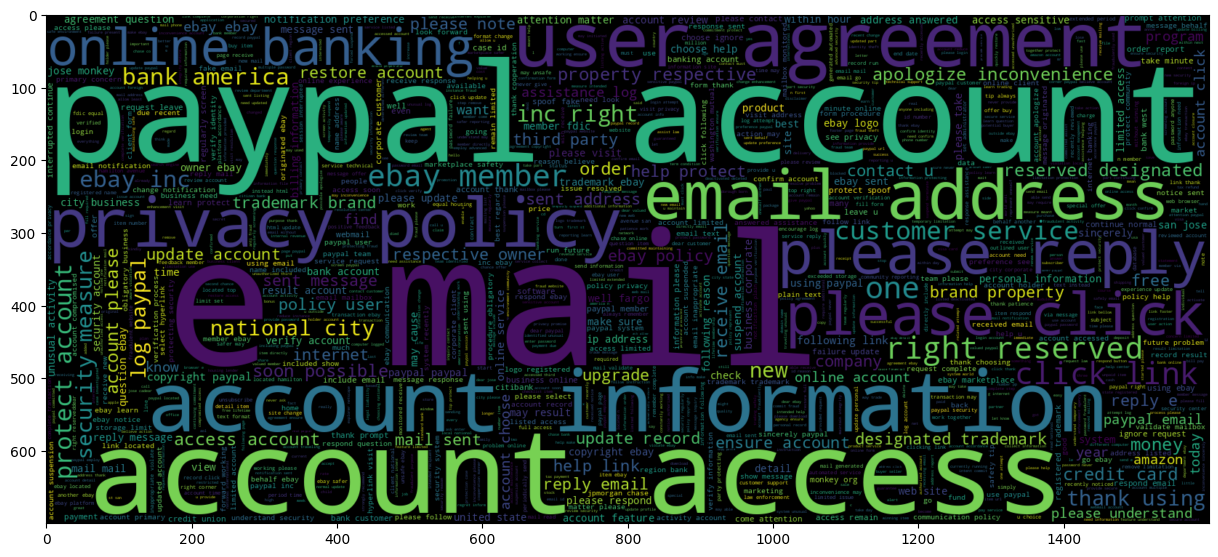

In [18]:
#word used in Real news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(df_train[df_train
                                                                                              .label== 1].text))
plt.imshow(wc, interpolation="bilinear")
del wc
gc.collect()

3585

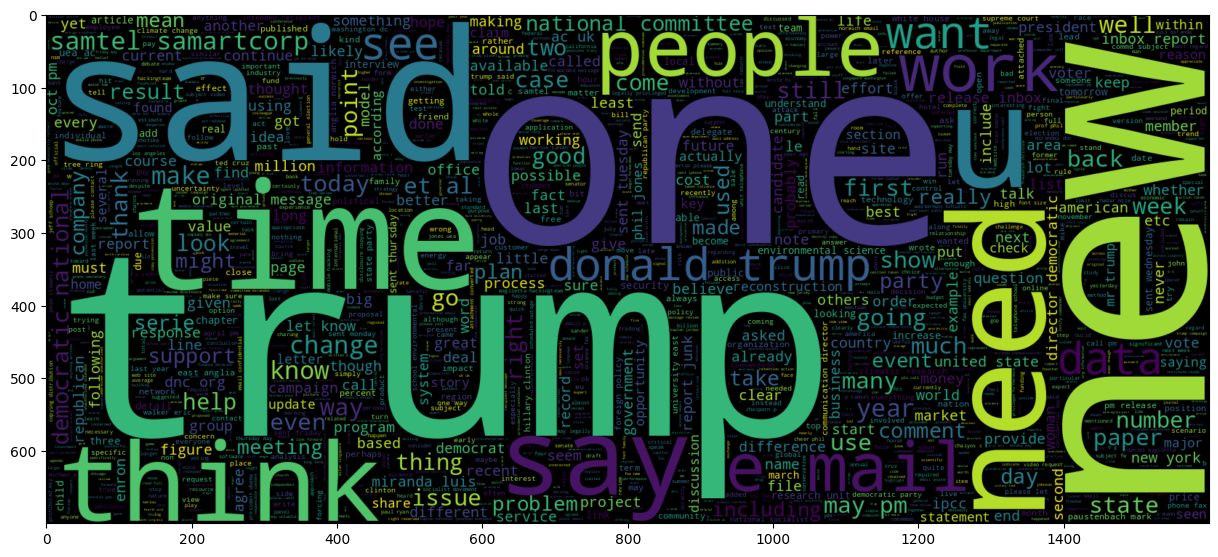

In [19]:
#word used in Fake news
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(df_train[df_train
                                                                                              .label== 0].text))
plt.imshow(wc, interpolation="bilinear")
del wc
gc.collect()

# Transformer

In [20]:
!pip install transformers

In [21]:
import torch
import time
import torch.nn as nn
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score

# paramters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)

device: cuda


In [22]:
train_text, train_labels=df_train['text'], df_train['label']
val_text, val_labels=df_valid['text'], df_valid['label']
test_text, test_labels=df_test['text'], df_test['label']

In [23]:
# check class distribution
df_train['label'].value_counts(normalize = True)

label
0    0.59
1    0.41
Name: proportion, dtype: float64

# Import BERT Model and BERT Tokenizer

In [24]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Tokenization

160

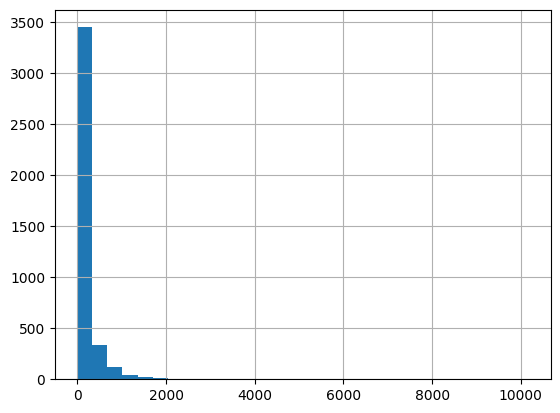

In [25]:
# get length of all the reviews in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
#del seq_len
gc.collect()

In [26]:
print(max(seq_len))

10168


5201

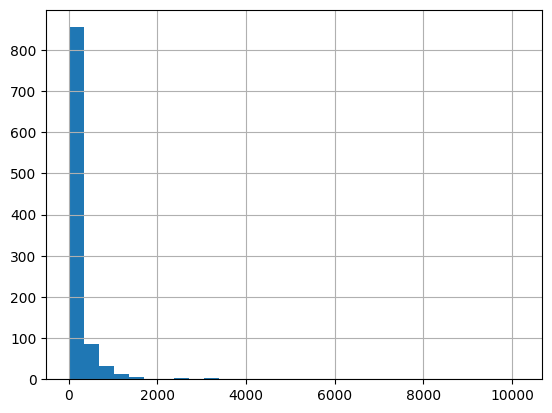

In [27]:
# get length of all the reviews in the train set
seq_len = [len(i.split()) for i in val_text]

pd.Series(seq_len).hist(bins = 30)
del seq_len
gc.collect()

5331

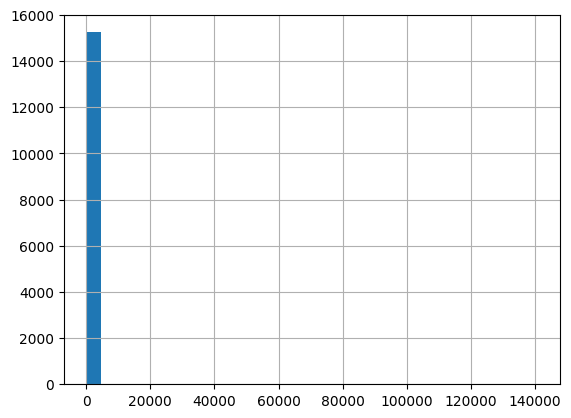

In [28]:
# get length of all the reviews in the train set
seq_len = [len(i.split()) for i in test_text]

pd.Series(seq_len).hist(bins = 30)
del seq_len
gc.collect()

In [29]:
max_seq_len = 512
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding="max_length",
    truncation=True,
    return_token_type_ids=True,
    add_special_tokens = True,
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding="max_length",
    truncation=True,
    return_token_type_ids=True,
    add_special_tokens = True,
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding="max_length",
    truncation=True,
    return_token_type_ids=True,
    add_special_tokens = True,
)
del max_seq_len
gc.collect()

5514

# Convert Integer Sequences to Tensors

In [30]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
del tokens_train
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
del tokens_val
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
del tokens_test
gc.collect()

0

# Create DataLoaders

In [31]:
#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
del train_data
del train_sampler
gc.collect()
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
del val_data
del val_sampler
gc.collect()

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during testing
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)
del test_data
del test_sampler
gc.collect()

0

# Define Model Architecture

In [32]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,
)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
# optimizer from hugging face transformers
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 1e-5, 
                  eps = 1e-8 
                )


# Find Class Weights

In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.84745763 1.2195122 ]


In [35]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
criterion  = nn.NLLLoss(weight=weights) 
del class_wts,weights
gc.collect()

36

# Fine-Tuning of BERT

In [36]:
!pip install tf-models-official

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.0 MB/s eta 0:00:0

In [37]:
!pip install datetime
import datetime

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 9.7 MB/s eta 0:00:00


In [38]:
def format_time(elapsed):

    '''

    Takes a time in seconds and returns a string hh:mm:ss

    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [39]:
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score,recall_score

In [40]:
import random
import numpy as np
listmodel=[]
seed_val = 42
random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
bestidx=0
# number of training epochs
epochs = 5
train_accuracy=[]
val_accuracy =[]
val_precision=[]
train_loss=[]
val_loss=[]
total_t0 = time.time()
best_score = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        model.zero_grad()
        out = model(input_ids, input_mask,labels=labels)
        del input_ids,input_mask
        gc.collect()
        logi = out.logits
        logits_tensor = torch.tensor(logi)
        loss = criterion(logits_tensor, labels)
        loss = out[0]
        logits = out[1]
        #print('Loss:',loss.item())
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
        pred = torch.argmax(logits_tensor, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()
        del pred,logits,logi,out,logits_tensor
        gc.collect()

    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)
    print("  Accuracy: {}".format(avg_train_accuracy))
    train_accuracy.append(avg_train_accuracy)
    print("  Training loss: {}".format(avg_train_loss))
    train_loss.append(avg_train_loss)
    training_time =time.time() - t0
    training_time=format_time(training_time)
    print("  Training time:{}".format(training_time))
    del avg_train_accuracy, avg_train_loss, training_time,t0
    gc.collect()
    # Validation
    print("")
    print("Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []
    t0=time.time()

    for batch in val_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        with torch.no_grad():
            out = model(input_ids, input_mask,labels=labels)
            del input_ids,input_mask
            gc.collect()
            loss = out[0]
            logi = out.logits
            logits_tensor = torch.tensor(logi)
        loss = criterion(logits_tensor, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(logits_tensor, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())
        del pred,logi,out,logits_tensor
        gc.collect()

    avg_val_accuracy = total_eval_accuracy / len(val_dataloader.dataset)
    avg_val_loss = total_eval_loss / len(val_dataloader.dataset)
    print("Validation loss: {}".format(avg_val_loss))
    val_loss.append(avg_val_loss)
    valid_time =time.time() - t0
    valid_time=format_time(valid_time)
    print("Validation time:{}".format(valid_time))
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
#     print('y_true',y_true)
#     print('y_pred',y_pred)
    val_acc=accuracy_score(y_true, y_pred)
    val_accuracy.append(val_acc)
    val_precision.append(precision_score(y_true, y_pred))
    print('Accuracy score:',val_acc)
    print('roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('Precision score:',precision_score(y_true, y_pred))
    print('F1 score:',f1_score(y_true, y_pred))
    print()
    listmodel.append(model)
    if precision_score(y_true, y_pred) > best_score:
        best_score = precision_score(y_true, y_pred)
        bestidx=epoch_i
    del val_acc, avg_val_accuracy, valid_time, avg_val_loss
    gc.collect()

print()
print('Best precision_score:',best_score)
print('Best model:',bestidx+1)
print("="*10)
print("Summary")
total=time.time()-total_t0
print("Total time {:} (h:mm:ss)",format_time(total))


Epoch 1 / 5
Training...
  Accuracy: 0.91475
  Training loss: 0.014368556963279844
  Training time:0:04:42

Validation...
Validation loss: -0.15469692730903625
Validation time:0:00:32
Accuracy score: 0.963
roc_auc score:  0.964853503132314
Precision score: 0.9377880184331797
F1 score: 0.9565217391304348


Epoch 2 / 5
Training...
  Accuracy: 0.9695
  Training loss: 0.0062667100532562475
  Training time:0:04:41

Validation...
Validation loss: -0.19795698380470275
Validation time:0:00:32
Accuracy score: 0.992
roc_auc score:  0.9921147130323186
Precision score: 0.9880668257756563
F1 score: 0.9904306220095694


Epoch 3 / 5
Training...
  Accuracy: 0.987
  Training loss: 0.003073901774609112
  Training time:0:04:40

Validation...
Validation loss: -0.23212135672569276
Validation time:0:00:32
Accuracy score: 0.994
roc_auc score:  0.9945127945670907
Precision score: 0.9881235154394299
F1 score: 0.9928400954653938


Epoch 4 / 5
Training...
  Accuracy: 0.99375
  Training loss: 0.001724038927510264

# Graphing

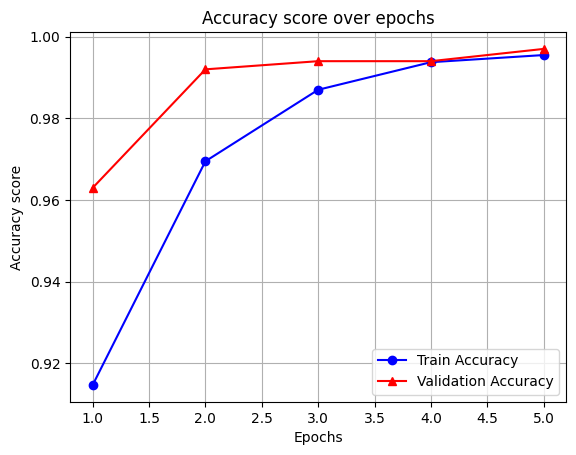

4067

In [41]:
import matplotlib.pyplot as plt
num_iterations=epochs
# Vẽ biểu đồ
# Define colors for the lines
train_color = 'blue'
val_color ='red'
plt.plot(range(1, num_iterations+1), train_accuracy,marker='o', label='Train Accuracy', color=train_color)
plt.plot(range(1, num_iterations+1), val_accuracy,marker='^', label='Validation Accuracy', color=val_color)
plt.xlabel('Epochs')
plt.ylabel('Accuracy score')
plt.title('Accuracy score over epochs')
plt.legend()
plt.grid(True)
plt.show()
del num_iterations
gc.collect()

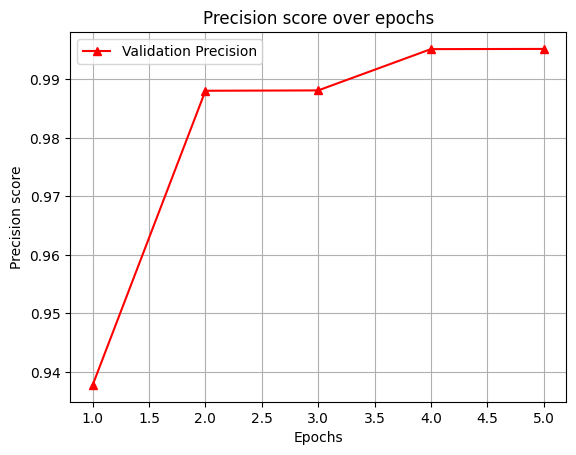

3992

In [42]:
num_iterations=epochs
# Vẽ biểu đồ
# Define colors for the lines
val_color ='red'
plt.plot(range(1, num_iterations+1), val_precision,marker='^', label='Validation Precision', color=val_color)
plt.xlabel('Epochs')
plt.ylabel('Precision score')
plt.title('Precision score over epochs')
plt.legend()
plt.grid(True)
plt.show()
del num_iterations
gc.collect()

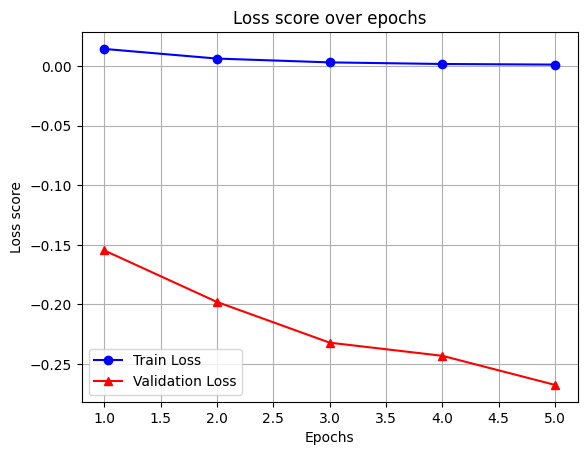

4113

In [43]:
import matplotlib.pyplot as plt
num_iterations=epochs
# Vẽ biểu đồ
# Define colors for the lines
train_color = 'blue'
val_color ='red'
plt.plot(range(1, num_iterations+1), train_loss,marker='o', label='Train Loss', color=train_color)
plt.plot(range(1, num_iterations+1), val_loss,marker='^', label='Validation Loss', color=val_color)
plt.xlabel('Epochs')
plt.ylabel('Loss score')
plt.title('Loss score over epochs')
plt.legend()
plt.grid(True)
plt.show()
del num_iterations, epochs
gc.collect()

# Testing

In [44]:
print(listmodel[bestidx].config)
pickle.dump(listmodel[bestidx], open('fakenews.sav', 'wb'))

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.42.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [45]:
total_t0 = time.time()
# Testing
print("")
print("Testing...")
use=listmodel[bestidx]
use.eval()
total_eval_accuracy = 0
total_eval_loss = 0
y_true = []
y_pred = []
t0=time.time()

for batch in test_dataloader:
    input_ids = batch[0].to(device)
    input_mask = batch[1].to(device)
    labels = batch[2].to(device)
    with torch.no_grad():
        out = model(input_ids, input_mask,labels=labels)
        del input_ids,input_mask
        gc.collect()
        loss = out[0]
        logi = out.logits
        logits_tensor = torch.tensor(logi)
    loss = criterion(logits_tensor, labels)
    total_eval_loss += loss.item()
    pred = torch.argmax(logits_tensor, dim = 1)
    total_eval_accuracy += torch.sum(pred == labels).item()
    y_true.append(labels.flatten())
    y_pred.append(pred.flatten())
    del pred,logi,out,logits_tensor
    gc.collect()

avg_val_accuracy = total_eval_accuracy / len(val_dataloader.dataset)
avg_val_loss = total_eval_loss / len(val_dataloader.dataset)
print("Testing loss: {}".format(avg_val_loss))
valid_time =time.time() - t0
valid_time=format_time(valid_time)
print("Testing time:{}".format(valid_time))
y_true = torch.cat(y_true).tolist()
y_pred = torch.cat(y_pred).tolist()
val_acc=accuracy_score(y_true, y_pred)
val_accuracy.append(val_acc)
print('Accuracy score:',val_acc)
print('roc_auc score: ', roc_auc_score(y_true,y_pred))
print('Precision score:',precision_score(y_true, y_pred))
print('Recall score:',recall_score(y_true, y_pred))
print('F1 score:',f1_score(y_true, y_pred))
print()

print("Summary")
print("Total time {:} (h:mm:ss)",format_time(time.time()-total_t0))


Testing...
Testing loss: -3.89610321354866
Testing time:0:08:11
Accuracy score: 0.9795049764274489
roc_auc score:  0.9789594171701154
Precision score: 0.9722905394326938
Recall score: 0.9762923938096806
F1 score: 0.9742873572660806

Summary
Total time {:} (h:mm:ss) 0:08:11


[[0.97229054 0.01569824]
 [0.02770946 0.98430176]]
Accuracy:  0.9795049764274489
Precision score: 0.9722905394326938
Recall score: 0.9762923938096806
F1-score:  0.9742873572660806


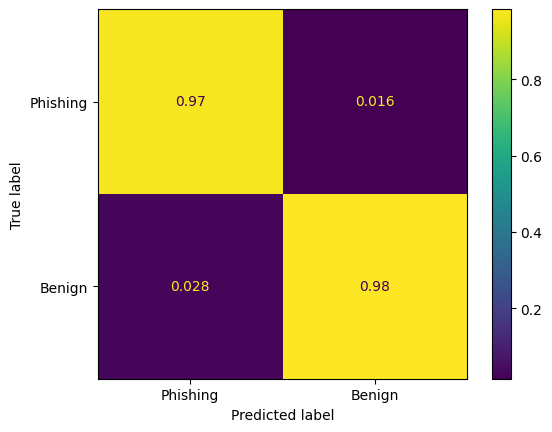

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=[1, 0], normalize='pred')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Phishing', 'Benign'])
disp.plot()

print('Accuracy: ', accuracy_score(y_pred,y_true))
print('Precision score:',precision_score(y_true, y_pred))
print('Recall score:',recall_score(y_true, y_pred))
print('F1-score: ', f1_score(y_pred,y_true))

In [47]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=['Benign', 'Phishing'])
print(report)

              precision    recall  f1-score   support

      Benign       0.98      0.98      0.98      9198
    Phishing       0.97      0.98      0.97      6074

    accuracy                           0.98     15272
   macro avg       0.98      0.98      0.98     15272
weighted avg       0.98      0.98      0.98     15272

